In [1]:
import os 
import healpy as hp
import numpy as np
import pylab as pl
import desitarget
import astropy.table as atable
import astropy.io.fits as fits
import matplotlib.pyplot as plt

from   desitarget.cuts import isBGS as official_isBGS
from   desitarget.targets import desi_mask, bgs_mask, mws_mask
from   astropy.table import Table, vstack, join
from   desitarget.mtl import inflate_ledger
from   desitarget.targetmask import bgs_mask

In [2]:
fpath = '/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/north/sweep/9.0/sweep-110p040-120p045.fits'

In [3]:
hdr   = fits.open(fpath)[0].header
hdr

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
ABIT_0  = 'badpix  '                                                            
ABIT_1  = 'satur   '                                                            
ABIT_11 = 'outlier '                                                            
ABIT_2  = 'interp  '                                                            
ABIT_4  = 'cr      '                                                            
ABIT_6  = 'bleed   '                                                            
ABIT_7  = 'trans   '        

#####  A sweep file contains the targets identified with high significance in the legacy imaging.  We then apply color/quality cuts to these to define the desi target classes.

In [6]:
sweep = Table.read(fpath)
sweep

RELEASE,BRICKID,BRICKNAME,OBJID,TYPE,RA,DEC,RA_IVAR,DEC_IVAR,DCHISQ [5],EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,NOBS_G,NOBS_R,NOBS_Z,NOBS_W1,NOBS_W2,NOBS_W3,NOBS_W4,RCHISQ_G,RCHISQ_R,RCHISQ_Z,RCHISQ_W1,RCHISQ_W2,RCHISQ_W3,RCHISQ_W4,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACFLUX_W1,FRACFLUX_W2,FRACFLUX_W3,FRACFLUX_W4,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,ANYMASK_G,ANYMASK_R,ANYMASK_Z,ALLMASK_G,ALLMASK_R,ALLMASK_Z,WISEMASK_W1,WISEMASK_W2,PSFSIZE_G,PSFSIZE_R,PSFSIZE_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,PSFDEPTH_W1,PSFDEPTH_W2,WISE_COADD_ID,SHAPE_R,SHAPE_R_IVAR,SHAPE_E1,SHAPE_E1_IVAR,SHAPE_E2,SHAPE_E2_IVAR,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,REF_CAT,REF_ID,REF_EPOCH,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,MASKBITS,FITBITS,SERSIC,SERSIC_IVAR
,,,,,deg,deg,1/deg^2,1/deg^2,,mag,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec,arcsec,arcsec,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,,arcsec,1/arcsec^2,,,,,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,,,,mag,,mag,,mag,,,,,,,mas,1/mas^2,mas / yr,1/(mas/yr)^2,mas / yr,1/(mas/yr)^2,,,,
int16,int32,bytes8,int32,bytes3,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,uint8,uint8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes2,int64,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,float32,uint8,float32,float32,float32,float32,float32,float32,int16,int16,float32,float32
9011,552082,1194p420,42,EXP,119.32969576972934,42.05642654051471,26915970000.0,37931594000.0,2384.4014 .. 2915.4683,0.041119073,1.164664,2.5052507,4.068865,-2.1098313,-11.168235,405.74197,6125.4565,451.39877,163.5678,77.68543,2.6957834,0.6716624,0.0008356708,1.1643888e-05,0.8853955,0.92127836,0.9551727,0.99305576,0.9957296,0.9990877,0.9996554,4,4,5,172,173,13,14,0.8612448,1.1506696,1.0679998,1.0555483,0.35786352,0.518118,0.08051461,0.06831313,0.038865436,0.08412386,18.60791,3.455831,0.9046269,1.1013702,0.016013531,0.008529627,0.0063300547,1.0,1.0,0.84500825,0,0,0,0,0,0,0,0,1.6437201,1.600499,1.2021023,1045.176,368.83905,217.22148,670.59424,244.37717,118.24639,4.1833167,0.8064833,1193p424,1.0403793,1471.652,-0.16867258,1216.3748,-0.4610675,1348.9606,0.46434033,0.99881923,1.6222173,0.46580964,1.00081,1.6342223,,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0,0.0
9011,552082,1194p420,43,REX,119.32974956872292,42.0195958754015,8298380300.0,8465178000.0,531.8265 .. 0.0,0.04068635,0.49322224,0.71428263,1.6946769,5.122245,2.896884,1.1909451,12.165278,659.883,245.6051,104.670555,3.206695,0.7351345,0.0008655035,1.13853675e-05,0.8865304,0.92

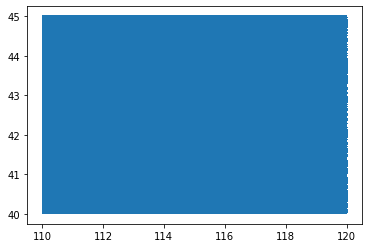

In [7]:
pl.plot(sweep['RA'].data, sweep['DEC'].data, marker=',', lw=0.0)

In [8]:
sweep.dtype.names

('RELEASE',
 'BRICKID',
 'BRICKNAME',
 'OBJID',
 'TYPE',
 'RA',
 'DEC',
 'RA_IVAR',
 'DEC_IVAR',
 'DCHISQ',
 'EBV',
 'FLUX_G',
 'FLUX_R',
 'FLUX_Z',
 'FLUX_W1',
 'FLUX_W2',
 'FLUX_W3',
 'FLUX_W4',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_Z',
 'FLUX_IVAR_W1',
 'FLUX_IVAR_W2',
 'FLUX_IVAR_W3',
 'FLUX_IVAR_W4',
 'MW_TRANSMISSION_G',
 'MW_TRANSMISSION_R',
 'MW_TRANSMISSION_Z',
 'MW_TRANSMISSION_W1',
 'MW_TRANSMISSION_W2',
 'MW_TRANSMISSION_W3',
 'MW_TRANSMISSION_W4',
 'NOBS_G',
 'NOBS_R',
 'NOBS_Z',
 'NOBS_W1',
 'NOBS_W2',
 'NOBS_W3',
 'NOBS_W4',
 'RCHISQ_G',
 'RCHISQ_R',
 'RCHISQ_Z',
 'RCHISQ_W1',
 'RCHISQ_W2',
 'RCHISQ_W3',
 'RCHISQ_W4',
 'FRACFLUX_G',
 'FRACFLUX_R',
 'FRACFLUX_Z',
 'FRACFLUX_W1',
 'FRACFLUX_W2',
 'FRACFLUX_W3',
 'FRACFLUX_W4',
 'FRACMASKED_G',
 'FRACMASKED_R',
 'FRACMASKED_Z',
 'FRACIN_G',
 'FRACIN_R',
 'FRACIN_Z',
 'ANYMASK_G',
 'ANYMASK_R',
 'ANYMASK_Z',
 'ALLMASK_G',
 'ALLMASK_R',
 'ALLMASK_Z',
 'WISEMASK_W1',
 'WISEMASK_W2',
 'PSFSIZE_G',
 'PSFSIZE_R',
 'PSFSIZE_

In [9]:
np.unique(sweep['TYPE'].data)

array([b'DEV', b'DUP', b'EXP', b'PSF', b'REX', b'SER'], dtype='|S3')

In [11]:
official_isBGS?

Signature:
official_isBGS(
    rfiberflux=None,
    gflux=None,
    rflux=None,
    zflux=None,
    rfibertotflux=None,
    w1flux=None,
    w2flux=None,
    gnobs=None,
    rnobs=None,
    znobs=None,
    gfluxivar=None,
    rfluxivar=None,
    zfluxivar=None,
    maskbits=None,
    Grr=None,
    refcat=None,
    w1snr=None,
    w2snr=None,
    gaiagmag=None,
    objtype=None,
    primary=None,
    south=True,
    targtype=None,
)
Docstring:
Definition of BGS target classes. Returns a boolean array.

Args
----
targtype: str, optional, defaults to ``faint``
    Pass ``bright`` for the ``BGS_BRIGHT`` selection.
    or ``faint`` for the ``BGS_FAINT`` selection
    or ``wise`` for the ``BGS_WISE`` (AGN-like) selection.

Returns
-------
:class:`array_like`
    ``True`` if the object is a BGS target of type ``targtype``.

Notes
-----
- Current version (05/11/21) is version 264 on `the wiki`_.
- See :func:`~desitarget.cuts.set_target_bits` for other parameters.
File:      /global/common/soft

In [12]:
rfiberflux=sweep['FIBERFLUX_R'].data.clip(1e-16) / sweep['MW_TRANSMISSION_R'].data

rfibertotflux=sweep['FIBERTOTFLUX_R'].data.clip(1e-16) / sweep['MW_TRANSMISSION_R'].data

gflux=sweep['FLUX_G'].data.clip(1e-16) / sweep['MW_TRANSMISSION_G'].data
rflux=sweep['FLUX_R'].data.clip(1e-16) / sweep['MW_TRANSMISSION_R'].data
zflux=sweep['FLUX_Z'].data.clip(1e-16) / sweep['MW_TRANSMISSION_Z'].data

w1flux=sweep['FLUX_W1'].data.clip(1e-16) / sweep['MW_TRANSMISSION_W1'].data
w2flux=sweep['FLUX_W2'].data.clip(1e-16) / sweep['MW_TRANSMISSION_W2'].data

gnobs=sweep['NOBS_G'].data
rnobs=sweep['NOBS_R'].data
znobs=sweep['NOBS_Z'].data
    
# EBV correction makes no difference to 0.0 for >0.0 cut.
gfluxivar=sweep['FLUX_IVAR_G'].data
rfluxivar=sweep['FLUX_IVAR_R'].data
zfluxivar=sweep['FLUX_IVAR_Z'].data

maskbits=sweep['MASKBITS'].data

# https://github.com/desihub/desitarget/blob/cba082b3b73bc0dfc0e8a790d50a8d5151ba1753/py/desitarget/cuts.py#L2179
gaiagmag = sweep['GAIA_PHOT_G_MEAN_MAG'].data

Grr = gaiagmag - 22.5 + 2.5*np.log10(1e-16)

ii = sweep['FLUX_R'] > 0

Grr[ii] = gaiagmag[ii] - 22.5 + 2.5*np.log10(sweep['FLUX_R'][ii])

refcat=sweep['REF_CAT'].data

w1snr=None
w2snr=None

gaiagmag=sweep['GAIA_PHOT_G_MEAN_MAG'].data

objtype=sweep['TYPE'].data

primary=None

In [13]:
np.sort(sweep['GAIA_PHOT_G_MEAN_MAG'].data)

array([ 0.      ,  0.      ,  0.      , ..., 21.433966, 21.449362,
       21.46798 ], dtype=float32)

In [15]:
in_north = sweep['DEC'] > 32.375
in_south = ~in_north

In [16]:
np.mean(in_north), np.mean(in_south)

(1.0, 0.0)

##### If you were to look at other sweep files containing bricks/targets below 32.375 in declination this would be True.  I assume there is no sweep file that crosses the boundary.

In [19]:
south=False

In [20]:
sweep_targets = {}

# targposs = ['faint', 'bright', 'faint_ext', 'lowq', 'fibmag']
for targtype in ['bright', 'faint']:
    isin_BGS =        official_isBGS(rfiberflux=rfiberflux,\
                                     gflux=gflux, rflux=rflux, zflux=zflux,\
                                     rfibertotflux=rfibertotflux,\
                                     w1flux=w1flux, w2flux=w2flux,\
                                     gnobs=gnobs, rnobs=rnobs, znobs=znobs,\
                                     gfluxivar=gfluxivar, rfluxivar=rfluxivar, zfluxivar=zfluxivar, 
                                     maskbits=maskbits,\
                                     Grr=Grr,\
                                     refcat=refcat,\
                                     w1snr=w1snr,\
                                     w2snr=w2snr,\
                                     gaiagmag=gaiagmag,\
                                     objtype=objtype,\
                                     primary=primary,\
                                     south=south,\
                                     targtype=targtype)

    sweep_targets[targtype] = sweep[isin_BGS]
    
    sweep_targets[targtype]['BRICK_OBJID'] = sweep_targets[targtype]['OBJID'] 

    del sweep_targets[targtype]['OBJID'] 
    
    print(targtype, 100. * np.mean(isin_BGS), np.count_nonzero(isin_BGS) / 50.)

bright 1.2857210072573935 666.76
faint 0.7222683731452535 374.56


In [21]:
nside=8

# Note: unbelievably, theta = ra when lonlat=True.
theta=sweep['RA'].data
phi=sweep['DEC'].data
lonlat=True, 
nest=True

idxs = hp.ang2pix(nside, theta, phi, lonlat=True, nest=nest)
idxs = np.unique(idxs)
idxs

array([ 99, 102, 103, 105, 108])

In [22]:
# theta, phi = hp.pixelfunc.lonlat2thetaphi(phi, theta)

In [23]:
# hp.ang2pix?

In [24]:
# idxs = [99]

In [26]:
btargets = []

for idx in idxs:
    btarget  = Table.read('/global/cfs/cdirs/desi/target/catalogs/dr9/1.1.1/targets/main/resolve/bright/targets-bright-hp-{:d}.fits'.format(idx), hdu=1)
    
    in_sweep = (btarget['DEC'].data > 40.) & (btarget['DEC'].data < 45.) & (btarget['RA'].data > 110.) & (btarget['RA'].data < 120.)

    btarget  = btarget[in_sweep] 
    
    btargets.append(btarget)
    
    # btargets = [Table.read('/global/cfs/cdirs/desi/target/catalogs/dr9/1.1.1/targets/main/resolve/bright/targets-bright-hp-{:d}.fits'.format(x), hdu=1) for x in idxs]
    # btargets = vstack(btargets)
    # btargets
    
    # btargets.pprint()
    
    print(idx, len(btarget))
    
btargets = vstack(btargets)

99 9703
102 85747
103 0
105 19542
108 25918


In [27]:
brights = btargets[(btargets['BGS_TARGET'].data & bgs_mask['BGS_BRIGHT']) != 0]
faints  = btargets[(btargets['BGS_TARGET'].data & bgs_mask['BGS_FAINT'])  != 0]

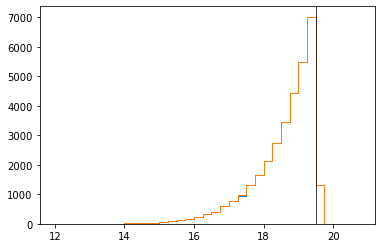

In [28]:
_ = pl.hist(22.5 - 2.5 * np.log10(sweep_targets['bright']['FLUX_R'].data / sweep_targets['bright']['MW_TRANSMISSION_R'].data), bins=np.arange(12., 21., 0.25), histtype='step')
_ = pl.hist(22.5 - 2.5 * np.log10(brights['FLUX_R'].data / brights['MW_TRANSMISSION_R'].data), bins=np.arange(12., 21., 0.25), histtype='step')

pl.axvline(19.5, c='k', lw=0.75)

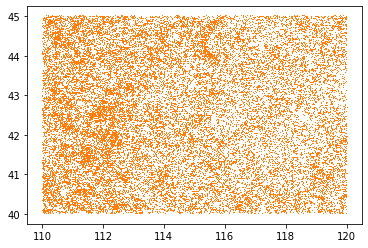

In [29]:
pl.plot(sweep_targets['bright']['RA'].data, sweep_targets['bright']['DEC'].data, marker=',', lw=0.0)
pl.plot(brights['RA'].data, brights['DEC'].data, marker=',', lw=0.0)

In [30]:
sweep_brickids = np.unique(sweep_targets['bright']['BRICKID'].data)

In [31]:
hp_brickids    = np.unique(brights['BRICKID'].data)

In [32]:
incommon_brickids = sweep_brickids[np.isin(sweep_brickids, hp_brickids)]
incommon_brickids

array([543327, 543328, 543329, 543330, 543331, 543332, 543333, 543334,
       543335, 543336, 543337, 543338, 543339, 543340, 543341, 543342,
       543343, 543344, 543345, 543346, 543347, 543348, 543349, 543350,
       543351, 543352, 543353, 543354, 543355, 543356, 543357, 543358,
       544432, 544433, 544434, 544435, 544436, 544437, 544438, 544439,
       544440, 544441, 544442, 544443, 544444, 544445, 544446, 544447,
       544448, 544449, 544450, 544451, 544452, 544453, 544454, 544455,
       544456, 544457, 544458, 544459, 544460, 544461, 544462, 544463,
       545533, 545534, 545535, 545536, 545537, 545538, 545539, 545540,
       545541, 545542, 545543, 545544, 545545, 545546, 545547, 545548,
       545549, 545550, 545551, 545552, 545553, 545554, 545555, 545556,
       545557, 545558, 545559, 545560, 545561, 545562, 545563, 546630,
       546631, 546632, 546633, 546634, 546635, 546636, 546637, 546638,
       546639, 546640, 546641, 546642, 546643, 546644, 546645, 546646,
      

In [33]:
sweep_targets['bright'] = join(sweep_targets['bright'], brights['BRICKID', 'BRICK_OBJID', 'TARGETID'], join_type='left', keys=['BRICKID', 'BRICK_OBJID'])
sweep_targets['faint']  = join(sweep_targets['faint'],   faints['BRICKID', 'BRICK_OBJID', 'TARGETID'], join_type='left', keys=['BRICKID', 'BRICK_OBJID'])

In [34]:
np.sort(sweep_targets['bright']['TARGETID'].data)

array([39633075990172430, 39633075994361925, 39633075994362030, ...,
       39633165484034426, 39633165484034676, 39633165484034700])

In [35]:
np.sort(sweep_targets['faint']['TARGETID'].data)

array([39633075990172264, 39633075990172293, 39633075990172493, ...,
       39633165484034367, 39633165484034679, 39633165484034714])

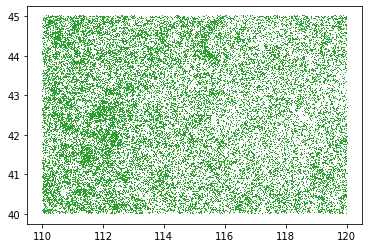

In [36]:
match = sweep_targets['bright']['TARGETID'].data >= 39633075990172430

pl.plot(sweep_targets['bright']['RA'].data, sweep_targets['bright']['DEC'].data, marker=',', lw=0.0)
pl.plot(brights['RA'].data, brights['DEC'].data, marker=',', lw=0.0)
pl.plot(sweep_targets['bright']['RA'].data[match], sweep_targets['bright']['DEC'].data[match], marker=',', lw=0.0)

In [37]:
brights = brights[brights['DEC'].data > 40.]
btids   = brights['TARGETID'].data

In [38]:
np.mean(np.isin(btids, sweep_targets['bright']['TARGETID'].data))

0.9991907687696688

In [39]:
faints  = faints[faints['DEC'].data > 40.]
ftids   = faints['TARGETID'].data

In [40]:
np.mean(np.isin(ftids, sweep_targets['faint']['TARGETID'].data))

1.0

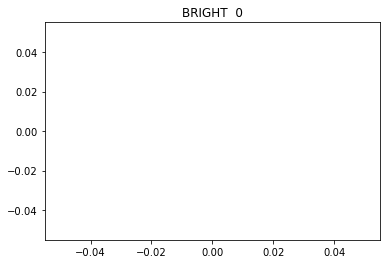

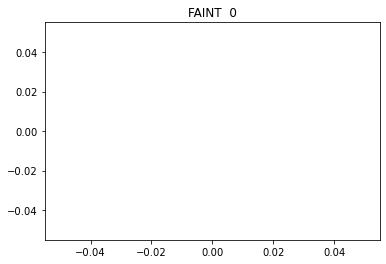

In [41]:
all_unmatched  = {} 

all_unmatched['bright'] = []
all_unmatched['faint']  = []

for targtype, tids in zip(['bright', 'faint'], [btids, ftids]):
    unmatched = ~np.isin(sweep_targets[targtype]['TARGETID'].data, tids)
    unmatched = sweep_targets[targtype][unmatched]
    
    all_unmatched[targtype].append(unmatched)
    
    pl.plot(unmatched['RA'].data, unmatched['DEC'].data, marker=',', lw=0.0)
    pl.title(targtype.upper() + '  {:d}'.format(len(unmatched)))
    pl.show()
    
all_unmatched['bright'] = vstack(all_unmatched['bright'])
all_unmatched['faint']  = vstack(all_unmatched['faint'])

#####  Here, we reproduce the main survey desitarget selection code and comment the (2) lines that impose a color-cut on BGS Faint.
https://github.com/desihub/desitarget/blob/cba082b3b73bc0dfc0e8a790d50a8d5151ba1753/py/desitarget/cuts.py#L2179

In [45]:
def _check_BGS_targtype(targtype):
    """Fail if `targtype` is not one 'bright', 'faint' or 'wise'.
    """
    targposs = ['faint', 'bright', 'wise']

    if targtype not in targposs:
        msg = 'targtype must be one of {} not {}'.format(targposs, targtype)
        log.critical(msg)
        raise ValueError(msg)

In [46]:
def isBGS_colors(rfiberflux=None, gflux=None, rflux=None, zflux=None,
                 w1flux=None, rfibertotflux=None, maskbits=None,
                 south=True, targtype=None, primary=None):
    """Standard color-based cuts used by all BGS target selection classes
    (see, e.g., :func:`~desitarget.cuts.isBGS` for parameters).
    """
    _check_BGS_targtype(targtype)

    # ADM to maintain backwards-compatibility with mocks.
    if rfiberflux is None:
        log.warning('Setting rfiberflux to rflux!!!')
        rfiberflux = rflux.copy()

    if primary is None:
        primary = np.ones_like(rflux, dtype='?')
    bgs = primary.copy()
    fmc = np.zeros_like(rflux, dtype='?')

    if south:
        bgs &= rflux > gflux * 10**(-1.0/2.5)
        bgs &= rflux < gflux * 10**(4.0/2.5)
        bgs &= zflux > rflux * 10**(-1.0/2.5)
        bgs &= zflux < rflux * 10**(4.0/2.5)
    else:
        bgs &= rflux > gflux * 10**(-1.0/2.5)
        bgs &= rflux < gflux * 10**(4.0/2.5)
        bgs &= zflux > rflux * 10**(-1.0/2.5)
        bgs &= zflux < rflux * 10**(4.0/2.5)

    g = 22.5 - 2.5*np.log10(gflux.clip(1e-16))
    r = 22.5 - 2.5*np.log10(rflux.clip(1e-16))
    z = 22.5 - 2.5*np.log10(zflux.clip(1e-16))
    w1 = 22.5 - 2.5*np.log10(w1flux.clip(1e-16))
    rfib = 22.5 - 2.5*np.log10(rfiberflux.clip(1e-16))

    # Fibre Magnitude Cut (FMC) -- This is a low surface brightness cut
    # with the aim of increase the redshift success rate.
    fmc |= ((rfib < (2.9 + 1.2 + 1.0) + r) & (r < 17.8))
    fmc |= ((rfib < 22.9) & (r < 20.0) & (r > 17.8))
    # ?????????????????????????????????????????????????????
    # Remove next line for the Main Survey?????????????????
    # ?????????????????????????????????????????????????????
    fmc |= ((rfib < 2.9 + r) & (r > 20))

    bgs &= fmc

    # BASS r-mag offset with DECaLS.
    offset = 0.04

    # D. Schlegel - ChangHoon H. color selection to get a high redshift
    # success rate.
    if south:
        schlegel_color = (z - w1) - 3/2.5 * (g - r) + 1.2
        rfibcol = (rfib < 20.75) | ((rfib < 21.5) & (schlegel_color > 0.))
    else:
        schlegel_color = (z - w1) - 3/2.5 * (g - (r-offset)) + 1.2
        rfibcol = (rfib < 20.75+offset) | ((rfib < 21.5+offset) &
                                           (schlegel_color > 0.))

    if targtype == 'bright':
        if south:
            bgs &= rflux > 10**((22.5-19.5)/2.5)
            bgs &= rflux <= 10**((22.5-12.0)/2.5)
            bgs &= rfibertotflux <= 10**((22.5-15.0)/2.5)
        else:
            bgs &= rflux > 10**((22.5-(19.5+offset))/2.5)
            bgs &= rflux <= 10**((22.5-12.0)/2.5)
            bgs &= rfibertotflux <= 10**((22.5-15.0)/2.5)

    elif targtype == 'faint':
        if south:
            bgs &= rflux > 10**((22.5-20.175)/2.5)
            bgs &= rflux <= 10**((22.5-19.5)/2.5)
            
            # Here we switch off the BGS Faint color selection.
            # bgs &= (rfibcol)
            
        else:
            bgs &= rflux > 10**((22.5-(20.220))/2.5)
            bgs &= rflux <= 10**((22.5-(19.5+offset))/2.5)
            
            # Here we switch off the BGS Faint color selection.
            # bgs &= (rfibcol)

    return bgs

In [47]:
def isBGS(rfiberflux=None, gflux=None, rflux=None, zflux=None, rfibertotflux=None,
          w1flux=None, w2flux=None, gnobs=None, rnobs=None, znobs=None,
          gfluxivar=None, rfluxivar=None, zfluxivar=None, maskbits=None,
          Grr=None, refcat=None, w1snr=None, w2snr=None, gaiagmag=None,
          objtype=None, primary=None, south=True, targtype=None):
    """Definition of BGS target classes. Returns a boolean array.
    Args
    ----
    targtype: str, optional, defaults to ``faint``
        Pass ``bright`` for the ``BGS_BRIGHT`` selection.
        or ``faint`` for the ``BGS_FAINT`` selection
        or ``wise`` for the ``BGS_WISE`` (AGN-like) selection.
    Returns
    -------
    :class:`array_like`
        ``True`` if the object is a BGS target of type ``targtype``.
    Notes
    -----
    - Current version (05/11/21) is version 264 on `the wiki`_.
    - See :func:`~desitarget.cuts.set_target_bits` for other parameters.
    """
    _check_BGS_targtype(targtype)

    # ADM to maintain backwards-compatibility with mocks.
    if rfiberflux is None:
        log.warning('Setting rfiberflux to rflux!!!')
        rfiberflux = rflux.copy()

    # ------ Bright Galaxy Survey
    if primary is None:
        primary = np.ones_like(rflux, dtype='?')
    bgs = primary.copy()

    if targtype == 'wise':
        bgs &= destarget.cuts.isBGS_wise(
            rfiberflux=rfiberflux, gflux=gflux, rflux=rflux, zflux=zflux,
            rfibertotflux=rfibertotflux, w1flux=w1flux, w2flux=w2flux,
            refcat=refcat, maskbits=maskbits,
            w1snr=w1snr, w2snr=w2snr, Grr=Grr, gaiagmag=gaiagmag,
            gfluxivar=gfluxivar, rfluxivar=rfluxivar, zfluxivar=zfluxivar,
            gnobs=gnobs, rnobs=rnobs, znobs=znobs, south=south,
            targtype=targtype, objtype=objtype, primary=primary
        )
    else:
        bgs &= desitarget.cuts.notinBGS_mask(
            gnobs=gnobs, rnobs=rnobs, znobs=znobs, primary=primary,
            gfluxivar=gfluxivar, rfluxivar=rfluxivar, zfluxivar=zfluxivar,
            Grr=Grr, gaiagmag=gaiagmag, maskbits=maskbits, targtype=targtype
        )
        bgs &= isBGS_colors(
            rfiberflux=rfiberflux, gflux=gflux, rflux=rflux, zflux=zflux,
            rfibertotflux=rfibertotflux, w1flux=w1flux, maskbits=maskbits,
            south=south, targtype=targtype, primary=primary
        )
        bgs |= desitarget.cuts.isBGS_sga(
            rfiberflux=rfiberflux, gflux=gflux, rflux=rflux, zflux=zflux,
            rfibertotflux=rfibertotflux, w1flux=w1flux, refcat=refcat,
            maskbits=maskbits, south=south, targtype=targtype
        )

    return bgs

In [48]:
# targposs = ['faint', 'bright', 'faint_ext', 'lowq', 'fibmag']
for targtype in ['bright', 'faint']:
    isin_BGS = isBGS(rfiberflux=rfiberflux,\
                     gflux=gflux, rflux=rflux, zflux=zflux,\
                     rfibertotflux=rfibertotflux,\
                     w1flux=w1flux, w2flux=w2flux,\
                     gnobs=gnobs, rnobs=rnobs, znobs=znobs,\
                     gfluxivar=gfluxivar, rfluxivar=rfluxivar, zfluxivar=zfluxivar, 
                     maskbits=maskbits,\
                     Grr=Grr,\
                     refcat=refcat,\
                     w1snr=w1snr,\
                     w2snr=w2snr,\
                     gaiagmag=gaiagmag,\
                     objtype=objtype,\
                     primary=primary,\
                     south=south,\
                     targtype=targtype)

    targtype = 'mjw_{}'.format(targtype)
    
    sweep_targets[targtype] = sweep[isin_BGS]    
    sweep_targets[targtype]['BRICK_OBJID'] = sweep_targets[targtype]['OBJID'] 

    del sweep_targets[targtype]['OBJID'] 
    
    print(targtype, 100. * np.mean(isin_BGS), np.count_nonzero(isin_BGS) / 50.)

mjw_bright 1.2857210072573935 666.76
mjw_faint 1.2395957950467076 642.84


In [49]:
sweep_targets.keys()

dict_keys(['bright', 'faint', 'mjw_bright', 'mjw_faint'])

In [50]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Text(0, 0.5, '$(z-W1)-1.2(g-r)+1.2$')

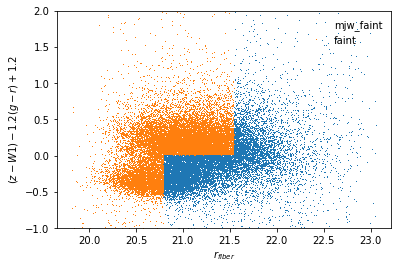

In [51]:
offset = 0.04

for i, targtype in enumerate(['mjw_faint', 'faint']):
    sample = sweep_targets[targtype]
    
    rfiberflux=sample['FIBERFLUX_R'].data.clip(1e-16) / sample['MW_TRANSMISSION_R'].data
    rfibertotflux=sample['FIBERTOTFLUX_R'].data.clip(1e-16) / sample['MW_TRANSMISSION_R'].data

    gflux=sample['FLUX_G'].data.clip(1e-16) / sample['MW_TRANSMISSION_G'].data
    rflux=sample['FLUX_R'].data.clip(1e-16) / sample['MW_TRANSMISSION_R'].data
    zflux=sample['FLUX_Z'].data.clip(1e-16) / sample['MW_TRANSMISSION_Z'].data

    w1flux=sample['FLUX_W1'].data.clip(1e-16) / sample['MW_TRANSMISSION_W1'].data
    w2flux=sample['FLUX_W2'].data.clip(1e-16) / sample['MW_TRANSMISSION_W2'].data
    
    rmag    = 22.5 - 2.5 * np.log10(rflux)
    rfibmag = 22.5 - 2.5 * np.log10(rfiberflux)
    
    gmag = 22.5 - 2.5*np.log10(gflux)
    zmag = 22.5 - 2.5*np.log10(zflux)
    w1mag = 22.5 - 2.5*np.log10(w1flux)

    # Assumes North
    schlegel_color = (zmag - w1mag) - 3/2.5 * (gmag - (rmag-offset)) + 1.2
            
    pl.plot(rfibmag, schlegel_color, marker=',', lw=0.0, label=targtype, color=colors[i])
    pl.ylim(-1.0, 2.0)
    
pl.legend(frameon=False)    
pl.xlabel('$r_{fiber}$')
pl.ylabel('$(z-W1)-1.2(g-r)+1.2$')

Text(0.5, 0, '$r$')

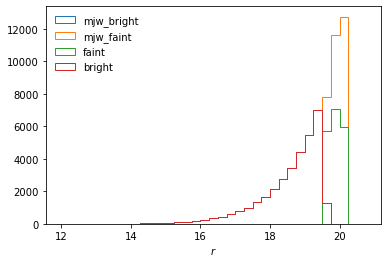

In [52]:
offset = 0.04

for i, targtype in enumerate(['mjw_bright', 'mjw_faint', 'faint', 'bright']):
    sample = sweep_targets[targtype]
    
    rfiberflux=sample['FIBERFLUX_R'].data.clip(1e-16) / sample['MW_TRANSMISSION_R'].data
    rfibertotflux=sample['FIBERTOTFLUX_R'].data.clip(1e-16) / sample['MW_TRANSMISSION_R'].data

    gflux=sample['FLUX_G'].data.clip(1e-16) / sample['MW_TRANSMISSION_G'].data
    rflux=sample['FLUX_R'].data.clip(1e-16) / sample['MW_TRANSMISSION_R'].data
    zflux=sample['FLUX_Z'].data.clip(1e-16) / sample['MW_TRANSMISSION_Z'].data

    w1flux=sample['FLUX_W1'].data.clip(1e-16) / sample['MW_TRANSMISSION_W1'].data
    w2flux=sample['FLUX_W2'].data.clip(1e-16) / sample['MW_TRANSMISSION_W2'].data
    
    rmag    = 22.5 - 2.5 * np.log10(rflux)
    rfibmag = 22.5 - 2.5 * np.log10(rfiberflux)
    
    gmag = 22.5 - 2.5*np.log10(gflux)
    zmag = 22.5 - 2.5*np.log10(zflux)
    w1mag = 22.5 - 2.5*np.log10(w1flux)

    # Assumes North
    schlegel_color = (zmag - w1mag) - 3/2.5 * (gmag - (rmag-offset)) + 1.2
            
    pl.hist(rmag, bins=np.arange(12., 21., 0.25), histtype='step', label=targtype)
        
pl.legend(frameon=False, loc=2)    
pl.xlabel('$r$')

Text(0.5, 0, '$(g-r)$')

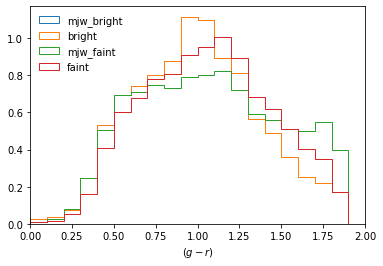

In [53]:
offset = 0.04

for i, targtype in enumerate(['mjw_bright', 'bright', 'mjw_faint', 'faint']):
    sample = sweep_targets[targtype]
    
    rfiberflux=sample['FIBERFLUX_R'].data.clip(1e-16) / sample['MW_TRANSMISSION_R'].data
    rfibertotflux=sample['FIBERTOTFLUX_R'].data.clip(1e-16) / sample['MW_TRANSMISSION_R'].data

    gflux=sample['FLUX_G'].data.clip(1e-16) / sample['MW_TRANSMISSION_G'].data
    rflux=sample['FLUX_R'].data.clip(1e-16) / sample['MW_TRANSMISSION_R'].data
    zflux=sample['FLUX_Z'].data.clip(1e-16) / sample['MW_TRANSMISSION_Z'].data

    w1flux=sample['FLUX_W1'].data.clip(1e-16) / sample['MW_TRANSMISSION_W1'].data
    w2flux=sample['FLUX_W2'].data.clip(1e-16) / sample['MW_TRANSMISSION_W2'].data
    
    rmag    = 22.5 - 2.5 * np.log10(rflux)
    rfibmag = 22.5 - 2.5 * np.log10(rfiberflux)
    
    gmag = 22.5 - 2.5*np.log10(gflux)
    zmag = 22.5 - 2.5*np.log10(zflux)
    w1mag = 22.5 - 2.5*np.log10(w1flux)

    gmr = gmag - rmag
    
    # Assumes North
    schlegel_color = (zmag - w1mag) - 3/2.5 * (gmag - (rmag-offset)) + 1.2
            
    pl.hist(gmr, bins=np.arange(0.0, 2.0, 0.1), histtype='step', label=targtype, density=True)
        
pl.xlim(0.0, 2.0)
pl.legend(frameon=False, loc=2)    
pl.xlabel('$(g-r)$')

# Done.